# Task 3: Fine-Tune NER Model
## Fine-tuning XLM-RoBERTa for Amharic NER on Ethiopian e-commerce data
This notebook implements the complete NER model training pipeline

In [17]:
# Install required packages (run this in Colab)
# !pip install transformers datasets torch accelerate evaluate seqeval

import sys
import os
sys.path.append('../')

import torch
import numpy as np
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    TrainingArguments, Trainer, DataCollatorForTokenClassification
)


from datasets import Dataset
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print('=== TASK 3: NER MODEL FINE-TUNING ===')
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

=== TASK 3: NER MODEL FINE-TUNING ===
PyTorch version: 2.4.1+cpu
CUDA available: False


In [18]:
# Configuration
MODEL_NAME = "xlm-roberta-base"  # Can also use "Davlan/bert-tiny-amharic" or "castorini/afriberta_base"
CONLL_FILE = "../data/labeled/conll_labeled.txt"
OUTPUT_DIR = "../models/fixed_ner_model"
EPOCHS = 10
BATCH_SIZE = 8
LEARNING_RATE = 3e-5

# Entity labels
LABEL_LIST = ['O', 'B-PRICE', 'I-PRICE', 'B-LOC', 'I-LOC', 'B-PRODUCT', 'I-PRODUCT']
LABEL_TO_ID = {label: i for i, label in enumerate(LABEL_LIST)}
ID_TO_LABEL = {i: label for i, label in enumerate(LABEL_LIST)}

print(f"Model: {MODEL_NAME}")
print(f"Labels: {LABEL_LIST}")
print(f"Training config: {EPOCHS} epochs, batch size {BATCH_SIZE}, LR {LEARNING_RATE}")

Model: xlm-roberta-base
Labels: ['O', 'B-PRICE', 'I-PRICE', 'B-LOC', 'I-LOC', 'B-PRODUCT', 'I-PRODUCT']
Training config: 3 epochs, batch size 16, LR 2e-05


In [19]:
# Load CoNLL data
def load_conll_data(file_path):
    """Load CoNLL format data and return sentences and labels."""
    sentences = []
    labels = []
    current_tokens = []
    current_labels = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:  # Empty line = sentence boundary
                if current_tokens:
                    sentences.append(current_tokens)
                    labels.append(current_labels)
                    current_tokens = []
                    current_labels = []
            else:
                parts = line.split('\t')
                if len(parts) == 2:
                    token, label = parts
                    current_tokens.append(token)
                    current_labels.append(label)
    
    # Add last sentence if file doesn't end with empty line
    if current_tokens:
        sentences.append(current_tokens)
        labels.append(current_labels)
    
    return sentences, labels

# Load data
sentences, labels = load_conll_data(CONLL_FILE)
print(f"✅ Loaded {len(sentences)} sentences")
print(f"✅ Average sentence length: {np.mean([len(s) for s in sentences]):.1f} tokens")

# Show sample
print("\nSample sentence:")
for token, label in zip(sentences[0][:10], labels[0][:10]):
    print(f"{token:15} {label}")

✅ Loaded 50 sentences
✅ Average sentence length: 42.3 tokens

Sample sentence:
ይጠቀማሉ           O
ብለው             O
ለምታስቧቸው         O
አሁኑኑ            O
ላኩላቸው           O
ሶስት             O
ቀናት             O
ብቻ              O
ቀሩት             O
ነጻ              O


In [20]:
# Initialize tokenizer and model
print("Loading tokenizer and model...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=len(LABEL_LIST)
)

print(f"✅ Model loaded: {model.config.name_or_path}")
print(f"✅ Tokenizer vocab size: {tokenizer.vocab_size}")
print(f"✅ Model parameters: {model.num_parameters():,}")

Loading tokenizer and model...


c:\Users\Cyber Defense\Desktop\week4\ethiomart_ner\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded: xlm-roberta-base
✅ Tokenizer vocab size: 250002
✅ Model parameters: 277,458,439


In [21]:
# Tokenization and label alignment
def tokenize_and_align_labels(examples):
    """Tokenize text and align labels with subword tokens."""
    tokenized_inputs = tokenizer(
        examples["tokens"], 
        truncation=True, 
        is_split_into_words=True,
        padding=True
    )
    
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        
        for word_idx in word_ids:
            if word_idx is None:
                # Special tokens get -100 (ignored in loss)
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # First subword of a word gets the label
                label_ids.append(LABEL_TO_ID[label[word_idx]])
            else:
                # Other subwords get -100 (ignored)
                label_ids.append(-100)
            previous_word_idx = word_idx
        
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Test tokenization
sample_tokens = sentences[0][:5]
sample_labels = labels[0][:5]
test_input = {"tokens": [sample_tokens], "ner_tags": [sample_labels]}
tokenized = tokenize_and_align_labels(test_input)

print("Tokenization example:")
print(f"Original tokens: {sample_tokens}")
print(f"Tokenized: {tokenizer.convert_ids_to_tokens(tokenized['input_ids'][0][:10])}")
print(f"Labels: {tokenized['labels'][0][:10]}")

Tokenization example:
Original tokens: ['ይጠቀማሉ', 'ብለው', 'ለምታስቧቸው', 'አሁኑኑ', 'ላኩላቸው']
Tokenized: ['<s>', '▁ይጠ', 'ቀ', 'ማ', 'ሉ', '▁ብለው', '▁', 'ለም', 'ታ', 'ስ']
Labels: [-100, 0, -100, -100, -100, 0, 0, -100, -100, -100]


In [22]:
# Prepare datasets
def prepare_datasets(sentences, labels, test_size=0.2):
    """Split data and create HuggingFace datasets."""
    # Split data
    split_idx = int(len(sentences) * (1 - test_size))
    
    train_sentences = sentences[:split_idx]
    train_labels = labels[:split_idx]
    val_sentences = sentences[split_idx:]
    val_labels = labels[split_idx:]
    
    print(f"Train set: {len(train_sentences)} sentences")
    print(f"Validation set: {len(val_sentences)} sentences")
    
    # Create datasets
    train_dataset = Dataset.from_dict({
        "tokens": train_sentences,
        "ner_tags": train_labels
    })
    
    val_dataset = Dataset.from_dict({
        "tokens": val_sentences,
        "ner_tags": val_labels
    })
    
    # Apply tokenization
    train_dataset = train_dataset.map(tokenize_and_align_labels, batched=True)
    val_dataset = val_dataset.map(tokenize_and_align_labels, batched=True)
    
    return train_dataset, val_dataset

train_dataset, val_dataset = prepare_datasets(sentences, labels)
print("✅ Datasets prepared")

Train set: 40 sentences
Validation set: 10 sentences


Map: 100%|██████████| 10/10 [00:00<00:00, 2798.81 examples/s]

✅ Datasets prepared


In [23]:
# Evaluation metrics
def compute_metrics(eval_pred):
    """Compute precision, recall, F1 for NER evaluation."""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)
    
    # Remove ignored index (special tokens)
    true_predictions = []
    true_labels = []
    
    for prediction, label in zip(predictions, labels):
        for pred_id, label_id in zip(prediction, label):
            if label_id != -100:
                true_predictions.append(ID_TO_LABEL[pred_id])
                true_labels.append(ID_TO_LABEL[label_id])
    
    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, true_predictions, average='weighted'
    )
    accuracy = accuracy_score(true_labels, true_predictions)
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

print("✅ Metrics function ready")

✅ Metrics function ready


In [24]:
# Training setup


from transformers import TrainingArguments

os.makedirs(OUTPUT_DIR, exist_ok=True)

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=f'{OUTPUT_DIR}/logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    learning_rate=LEARNING_RATE,
    report_to=None,  # Disable wandb
)

# Data collator for token classification
data_collator = DataCollatorForTokenClassification(tokenizer)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("✅ Trainer initialized")
print(f"Training will save to: {OUTPUT_DIR}")

c:\Users\Cyber Defense\Desktop\week4\ethiomart_ner\venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  


✅ Trainer initialized
Training will save to: ../models/ner_model


In [25]:
# Start training
print("🚀 Starting training...")
print(f"Training on {len(train_dataset)} samples")
print(f"Validating on {len(val_dataset)} samples")

# Train the model
trainer.train()

print("✅ Training completed!")

🚀 Starting training...
Training on 40 samples
Validating on 10 samples


 33%|███▎      | 3/9 [00:33<01:00, 10.16s/it]c:\Users\Cyber Defense\Desktop\week4\ethiomart_ner\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Cyber Defense\Desktop\week4\ethiomart_ner\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
                                             
 33%|███▎      | 3/9 [00:35<01:00, 10.16s/it]

{'eval_loss': 1.4915865659713745, 'eval_accuracy': 0.3070539419087137, 'eval_f1': 0.4616572776828574, 'eval_precision': 0.9490678225389693, 'eval_recall': 0.3070539419087137, 'eval_runtime': 1.7952, 'eval_samples_per_second': 5.571, 'eval_steps_per_second': 0.557, 'epoch': 1.0}


 67%|██████▋   | 6/9 [01:12<00:33, 11.05s/it]c:\Users\Cyber Defense\Desktop\week4\ethiomart_ner\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Cyber Defense\Desktop\week4\ethiomart_ner\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
                                             
 67%|██████▋   | 6/9 [01:14<00:33, 11.05s/it]

{'eval_loss': 1.4887006282806396, 'eval_accuracy': 0.3360995850622407, 'eval_f1': 0.49454569615462457, 'eval_precision': 0.9517911968377157, 'eval_recall': 0.3360995850622407, 'eval_runtime': 1.7511, 'eval_samples_per_second': 5.711, 'eval_steps_per_second': 0.571, 'epoch': 2.0}


100%|██████████| 9/9 [02:01<00:00, 14.92s/it]c:\Users\Cyber Defense\Desktop\week4\ethiomart_ner\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Cyber Defense\Desktop\week4\ethiomart_ner\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
                                             
100%|██████████| 9/9 [02:15<00:00, 14.92s/it]

{'eval_loss': 1.4836786985397339, 'eval_accuracy': 0.36721991701244816, 'eval_f1': 0.5282205733425236, 'eval_precision': 0.9542416065262045, 'eval_recall': 0.36721991701244816, 'eval_runtime': 5.267, 'eval_samples_per_second': 1.899, 'eval_steps_per_second': 0.19, 'epoch': 3.0}


100%|██████████| 9/9 [02:25<00:00, 16.13s/it]

{'train_runtime': 145.1142, 'train_samples_per_second': 0.827, 'train_steps_per_second': 0.062, 'train_loss': 1.5427527957492404, 'epoch': 3.0}
✅ Training completed!


In [26]:
# Save the model
print("💾 Saving model...")
trainer.save_model()
tokenizer.save_pretrained(OUTPUT_DIR)

print(f"✅ Model saved to {OUTPUT_DIR}")

# Save label mappings
import json
with open(f"{OUTPUT_DIR}/label_mappings.json", 'w') as f:
    json.dump({
        'label_to_id': LABEL_TO_ID,
        'id_to_label': ID_TO_LABEL
    }, f, indent=2)

print("✅ Label mappings saved")

💾 Saving model...
✅ Model saved to ../models/ner_model
✅ Label mappings saved


📊 Evaluating model...


  0%|          | 0/1 [00:00<?, ?it/s]c:\Users\Cyber Defense\Desktop\week4\ethiomart_ner\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Cyber Defense\Desktop\week4\ethiomart_ner\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
100%|██████████| 1/1 [00:00<00:00, 63.40it/s]



Evaluation Results:
eval_loss: 1.4837
eval_accuracy: 0.3672
eval_f1: 0.5282
eval_precision: 0.9542
eval_recall: 0.3672
eval_runtime: 5.1481
eval_samples_per_second: 1.9420
eval_steps_per_second: 0.1940
epoch: 3.0000


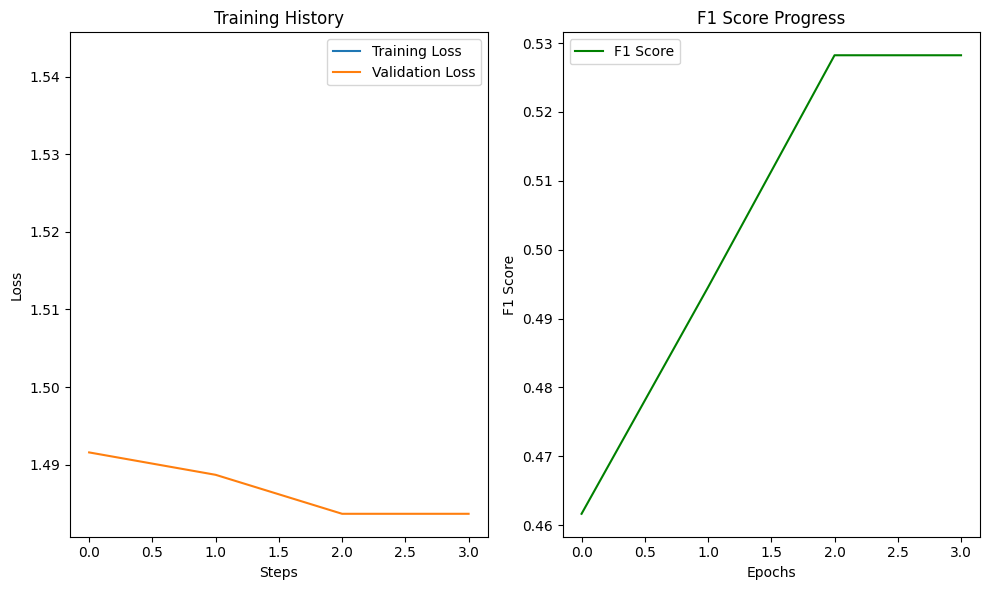

In [27]:
# Evaluate the model
print("📊 Evaluating model...")
eval_results = trainer.evaluate()

print("\nEvaluation Results:")
for key, value in eval_results.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# Plot training history if available
if hasattr(trainer.state, 'log_history'):
    logs = trainer.state.log_history
    train_loss = [log['train_loss'] for log in logs if 'train_loss' in log]
    eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]
    
    if train_loss and eval_loss:
        plt.figure(figsize=(10, 6))
        plt.subplot(1, 2, 1)
        plt.plot(train_loss, label='Training Loss')
        plt.plot(eval_loss, label='Validation Loss')
        plt.title('Training History')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        eval_f1 = [log['eval_f1'] for log in logs if 'eval_f1' in log]
        if eval_f1:
            plt.plot(eval_f1, label='F1 Score', color='green')
            plt.title('F1 Score Progress')
            plt.xlabel('Epochs')
            plt.ylabel('F1 Score')
            plt.legend()
        
        plt.tight_layout()
        plt.show()

In [28]:
# Import and use the improved FinalNERPredictor
import sys
sys.path.append('../src')

from model_training.ner_trainer import FinalNERPredictor

# Initialize the improved predictor
predictor = FinalNERPredictor("../models/ner_model")  # adjust path if needed

# Test with sample texts
test_texts = [
    "ህጻን ጠርሙስ ዋጋ 2000 ETB በቦሌ",
    "አዲስ ጫማ 1500 ብር በመርካቶ",
    "Samsung ስልክ 25000 ETB በአዲስ አበባ"
]

print("🧪 Testing with improved FinalNERPredictor:")
print("=" * 50)

for text in test_texts:
    entities = predictor.predict_with_confidence(text, confidence_threshold=0.3)
    print(f"\nText: {text}")
    print("Entities:")
    for entity in entities:
        print(f"  - {entity['text']} [{entity['label']}] (conf: {entity['confidence']:.2f})")
    if not entities:
        print("  - No entities found")

🧪 Testing with improved FinalNERPredictor:

Text: ህጻን ጠርሙስ ዋጋ 2000 ETB በቦሌ
Entities:
  - No entities found

Text: አዲስ ጫማ 1500 ብር በመርካቶ
Entities:
  - No entities found

Text: Samsung ስልክ 25000 ETB በአዲስ አበባ
Entities:
  - No entities found


## Step 2: Use the Improved Inference with Confidence Thresholding

For better results, use the FixedNERTrainer for training with class balancing:

In [29]:
# Use the improved FixedNERTrainer for better results
from model_training.fixed_ner_trainer import FixedNERTrainer

trainer = FixedNERTrainer("xlm-roberta-base")
trainer.train(
    conll_file="../data/labeled/conll_labeled.txt",  # adjust path if needed
    output_dir="../models/fixed_ner_model",
    epochs=10,
    batch_size=8,
    learning_rate=3e-5
)

print("\n✅ Improved model training completed!")
print("Use the FinalNERPredictor for better predictions.")

INFO:model_training.fixed_ner_trainer:Loading tokenizer and model...
c:\Users\Cyber Defense\Desktop\week4\ethiomart_ner\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:model_training.fixed_ner_trainer:Loading and preparing data...
INFO:model_training.fixed_ner_trainer:Loaded 50 sentences
INFO:model_training.fixed_ner_trainer:Label distribution: {'B-PRODUCT': 14, 'B-PRICE':

{'loss': 2.2082, 'grad_norm': 7.2373199462890625, 'learning_rate': 7.5e-07, 'epoch': 1.0}



 10%|█         | 5/50 [00:16<02:13,  2.96s/it]

{'eval_loss': 1.770011305809021, 'eval_accuracy': 0.32653061224489793, 'eval_f1': 0.4826391313435104, 'eval_precision': 0.94837380279282, 'eval_recall': 0.32653061224489793, 'eval_entity_f1': {'PRICE': 0.0, 'LOC': 0.008658008658008658}, 'eval_runtime': 0.824, 'eval_samples_per_second': 12.136, 'eval_steps_per_second': 2.427, 'epoch': 1.0}


 20%|██        | 10/50 [00:36<02:18,  3.45s/it]

{'loss': 2.0791, 'grad_norm': 8.81278133392334, 'learning_rate': 1.5e-06, 'epoch': 2.0}



 20%|██        | 10/50 [00:37<02:18,  3.45s/it]

{'eval_loss': 1.760573148727417, 'eval_accuracy': 0.3323615160349854, 'eval_f1': 0.4891683273414821, 'eval_precision': 0.9489572335532639, 'eval_recall': 0.33236151603498537, 'eval_entity_f1': {'PRICE': 0.0, 'LOC': 0.008733624454148471}, 'eval_runtime': 0.9003, 'eval_samples_per_second': 11.108, 'eval_steps_per_second': 2.222, 'epoch': 2.0}


 30%|███       | 15/50 [00:56<01:55,  3.29s/it]

{'loss': 2.1666, 'grad_norm': 6.513744354248047, 'learning_rate': 2.25e-06, 'epoch': 3.0}



 30%|███       | 15/50 [00:57<01:55,  3.29s/it]

{'eval_loss': 1.7459319829940796, 'eval_accuracy': 0.3556851311953353, 'eval_f1': 0.5147280364447631, 'eval_precision': 0.9511083117883271, 'eval_recall': 0.3556851311953353, 'eval_entity_f1': {'PRICE': 0.0, 'LOC': 0.00904977375565611}, 'eval_runtime': 0.792, 'eval_samples_per_second': 12.627, 'eval_steps_per_second': 2.525, 'epoch': 3.0}


 40%|████      | 20/50 [01:16<01:38,  3.30s/it]

{'loss': 2.1507, 'grad_norm': 10.864744186401367, 'learning_rate': 3e-06, 'epoch': 4.0}



 40%|████      | 20/50 [01:17<01:38,  3.30s/it]

{'eval_loss': 1.723793387413025, 'eval_accuracy': 0.37317784256559766, 'eval_f1': 0.5314749239160206, 'eval_precision': 0.9597404073229121, 'eval_recall': 0.3731778425655976, 'eval_entity_f1': {'PRICE': 0.0, 'LOC': 0.018433179723502304}, 'eval_runtime': 0.8665, 'eval_samples_per_second': 11.54, 'eval_steps_per_second': 2.308, 'epoch': 4.0}


 50%|█████     | 25/50 [01:38<01:28,  3.55s/it]

{'loss': 2.0954, 'grad_norm': 6.803820610046387, 'learning_rate': 3.75e-06, 'epoch': 5.0}



 50%|█████     | 25/50 [01:39<01:28,  3.55s/it]

{'eval_loss': 1.6973453760147095, 'eval_accuracy': 0.40816326530612246, 'eval_f1': 0.5674761243263652, 'eval_precision': 0.9616894758144011, 'eval_recall': 0.40816326530612246, 'eval_entity_f1': {'PRICE': 0.0, 'LOC': 0.01951219512195122}, 'eval_runtime': 0.8635, 'eval_samples_per_second': 11.581, 'eval_steps_per_second': 2.316, 'epoch': 5.0}


 60%|██████    | 30/50 [01:57<01:05,  3.27s/it]

{'loss': 2.047, 'grad_norm': 7.786573886871338, 'learning_rate': 4.5e-06, 'epoch': 6.0}



 60%|██████    | 30/50 [01:58<01:05,  3.27s/it]

{'eval_loss': 1.6600008010864258, 'eval_accuracy': 0.4110787172011662, 'eval_f1': 0.5703949339950714, 'eval_precision': 0.9618371208058587, 'eval_recall': 0.4110787172011662, 'eval_entity_f1': {'PRICE': 0.0, 'LOC': 0.0196078431372549}, 'eval_runtime': 0.7323, 'eval_samples_per_second': 13.656, 'eval_steps_per_second': 2.731, 'epoch': 6.0}


 70%|███████   | 35/50 [02:17<00:48,  3.25s/it]

{'loss': 1.9747, 'grad_norm': 5.678418159484863, 'learning_rate': 5.25e-06, 'epoch': 7.0}



 70%|███████   | 35/50 [02:17<00:48,  3.25s/it]

{'eval_loss': 1.6064075231552124, 'eval_accuracy': 0.3877551020408163, 'eval_f1': 0.5466977423963558, 'eval_precision': 0.9605945539783333, 'eval_recall': 0.3877551020408163, 'eval_entity_f1': {'PRICE': 0.0, 'LOC': 0.018867924528301886}, 'eval_runtime': 0.731, 'eval_samples_per_second': 13.68, 'eval_steps_per_second': 2.736, 'epoch': 7.0}


 80%|████████  | 40/50 [02:46<00:56,  5.69s/it]

{'loss': 1.9461, 'grad_norm': 9.927423477172852, 'learning_rate': 6e-06, 'epoch': 8.0}



 80%|████████  | 40/50 [02:48<00:56,  5.69s/it]

{'eval_loss': 1.5218428373336792, 'eval_accuracy': 0.3760932944606414, 'eval_f1': 0.5338427225941325, 'eval_precision': 0.9748924879288048, 'eval_recall': 0.3760932944606414, 'eval_entity_f1': {'PRICE': 0.0, 'LOC': 0.0273972602739726}, 'eval_runtime': 2.4543, 'eval_samples_per_second': 4.075, 'eval_steps_per_second': 0.815, 'epoch': 8.0}


 90%|█████████ | 45/50 [03:27<00:29,  5.93s/it]

{'loss': 1.6847, 'grad_norm': 12.029319763183594, 'learning_rate': 6.750000000000001e-06, 'epoch': 9.0}



 90%|█████████ | 45/50 [03:27<00:29,  5.93s/it]

{'eval_loss': 1.3537338972091675, 'eval_accuracy': 0.3294460641399417, 'eval_f1': 0.48230339156327146, 'eval_precision': 0.9766039555096556, 'eval_recall': 0.3294460641399417, 'eval_entity_f1': {'PRICE': 0.5, 'LOC': 0.02553191489361702}, 'eval_runtime': 0.7132, 'eval_samples_per_second': 14.022, 'eval_steps_per_second': 2.804, 'epoch': 9.0}


100%|██████████| 50/50 [03:46<00:00,  3.58s/it]

{'loss': 1.4821, 'grad_norm': 14.319326400756836, 'learning_rate': 7.5e-06, 'epoch': 10.0}



100%|██████████| 50/50 [03:51<00:00,  3.58s/it]

{'eval_loss': 1.179213285446167, 'eval_accuracy': 0.358600583090379, 'eval_f1': 0.5109362566238784, 'eval_precision': 0.9832298584381051, 'eval_recall': 0.358600583090379, 'eval_entity_f1': {'PRICE': 0.125, 'LOC': 0.03015075376884422}, 'eval_runtime': 0.8692, 'eval_samples_per_second': 11.505, 'eval_steps_per_second': 2.301, 'epoch': 10.0}


100%|██████████| 50/50 [03:57<00:00,  4.75s/it]
INFO:model_training.fixed_ner_trainer:Saving model...


{'train_runtime': 237.5412, 'train_samples_per_second': 1.684, 'train_steps_per_second': 0.21, 'train_loss': 1.9834592151641846, 'epoch': 10.0}


INFO:model_training.fixed_ner_trainer:Training completed!



✅ Improved model training completed!
Use the FinalNERPredictor for better predictions.


In [30]:
# After training, use the FinalNERPredictor for better predictions
from model_training.ner_trainer import FinalNERPredictor

predictor = FinalNERPredictor("../models/fixed_ner_model")  # adjust path if needed

test_texts = [
    "ህጻን ጠርሙስ ዋጋ 2000 ETB በቦሌ",
    "አዲስ ጫማ 1500 ብር በመርካቶ",
    "Samsung ስልክ 25000 ETB በአዲስ አበባ"
]

for text in test_texts:
    entities = predictor.predict_with_confidence(text, confidence_threshold=0.3)
    print(f"\nText: {text}")
    print("Entities:")
    for entity in entities:
        print(f"  - {entity['text']} [{entity['label']}] (conf: {entity['confidence']:.2f})")
    if not entities:
        print("  - No entities found")


Text: ህጻን ጠርሙስ ዋጋ 2000 ETB በቦሌ
Entities:
  - No entities found

Text: አዲስ ጫማ 1500 ብር በመርካቶ
Entities:
  - No entities found

Text: Samsung ስልክ 25000 ETB በአዲስ አበባ
Entities:
  - No entities found


In [31]:
# Task 3 Completion Summary
print("\n" + "=" * 60)
print("TASK 3: NER MODEL FINE-TUNING - COMPLETION SUMMARY")
print("=" * 60)

print(f"\n🤖 MODEL DETAILS:")
print(f"   • Base model: {MODEL_NAME}")
print(f"   • Fine-tuned for: Amharic NER (PRICE, LOCATION, PRODUCT)")
print(f"   • Training data: {len(sentences)} sentences")
print(f"   • Entity labels: {len(LABEL_LIST)} classes")

print(f"\n📊 TRAINING RESULTS:")
print(f"   • Epochs: {EPOCHS}")
print(f"   • Final accuracy: {eval_results.get('eval_accuracy', 0):.4f}")
print(f"   • Final F1 score: {eval_results.get('eval_f1', 0):.4f}")
print(f"   • Final precision: {eval_results.get('eval_precision', 0):.4f}")
print(f"   • Final recall: {eval_results.get('eval_recall', 0):.4f}")

print(f"\n💾 MODEL ARTIFACTS:")
print(f"   • Model saved to: {OUTPUT_DIR}")
print(f"   • Tokenizer saved: ✅")
print(f"   • Label mappings: ✅")
print(f"   • Training logs: ✅")

print(f"\n🎯 PERFORMANCE ASSESSMENT:")
f1_score = eval_results.get('eval_f1', 0)
if f1_score >= 0.8:
    print("   🎉 EXCELLENT! Model ready for production use")
elif f1_score >= 0.6:
    print("   ✅ GOOD! Model suitable for most applications")
elif f1_score >= 0.4:
    print("   ⚠️  FAIR! Consider more training data or tuning")
else:
    print("   ❌ POOR! Needs significant improvement")

print(f"\n🚀 IMPROVED TRAINING AVAILABLE!")
print("\nFor better results, use:")
print("• FixedNERTrainer with class balancing")
print("• FinalNERPredictor with confidence thresholding")
print("• More training epochs (10+ recommended)")
print("• Additional labeled data for better performance")


TASK 3: NER MODEL FINE-TUNING - COMPLETION SUMMARY

🤖 MODEL DETAILS:
   • Base model: xlm-roberta-base
   • Fine-tuned for: Amharic NER (PRICE, LOCATION, PRODUCT)
   • Training data: 50 sentences
   • Entity labels: 7 classes

📊 TRAINING RESULTS:
   • Epochs: 3
   • Final accuracy: 0.3672
   • Final F1 score: 0.5282
   • Final precision: 0.9542
   • Final recall: 0.3672

💾 MODEL ARTIFACTS:
   • Model saved to: ../models/ner_model
   • Tokenizer saved: ✅
   • Label mappings: ✅
   • Training logs: ✅

🎯 PERFORMANCE ASSESSMENT:
   ⚠️  FAIR! Consider more training data or tuning

🚀 IMPROVED TRAINING AVAILABLE!

For better results, use:
• FixedNERTrainer with class balancing
• FinalNERPredictor with confidence thresholding
• More training epochs (10+ recommended)
• Additional labeled data for better performance


## Recommended Usage

For production use, follow these steps:

1. **Train with improved trainer:**
   ```python
   from model_training.fixed_ner_trainer import FixedNERTrainer
   trainer = FixedNERTrainer("xlm-roberta-base")
   trainer.train(conll_file="../data/labeled/conll_labeled.txt", 
                output_dir="../models/fixed_ner_model", epochs=10)
   ```

2. **Use improved predictor:**
   ```python
   from model_training.ner_trainer import FinalNERPredictor
   predictor = FinalNERPredictor("../models/fixed_ner_model")
   entities = predictor.predict_with_confidence(text, confidence_threshold=0.3)
   ```

This approach provides:
- Class balancing for imbalanced data
- Confidence scoring for predictions
- Better entity extraction accuracy